In [1]:
import itertools
import pandas
import numpy
import glob
import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# settings
protocols = ['fotb', 'totb', 'htlltb', 'htlltbtest']
n_processes = [3, 6, 9, 12]
workload_time = 180
prefixes = [str(a) + "-" + str(b) for a,b in itertools.product(protocols, n_processes)]
colours = ["r", "g", "b", "k"]
markers = ["o", "v", "^", "x"]
linestyles = ['-','--',':','-.']


In [3]:
# check data
print("number of log files: %s" % len(glob.glob('../data/*.log')))
print("expected number of log files: %s" % (len(protocols) * sum(n_processes)))


number of log files: 120
expected number of log files: 120


In [4]:
# preprocessing
results = []

# for each prefix (i.e. benchmark run): fotb-3, ..., htlltbtest-12
for prefix in tqdm.tqdm(prefixes):
    # merge all logs for a prefix into a dataframe df, normalizing the time of each
    # individual history to the minimum time of that history.
    # ignore lines that start with { as these are error messages.
    # first line is the header line.
    # calculate the latency of a broadcast message, as the time difference between 
    # the broadcast and delivery of that message.
    # from the merged logs, we calculate summarizing statistics, 
    # and provide these for each prefix.
    files = glob.glob('../data/' + prefix + '*')
    df = []
    for file in files:
        d = pandas.read_csv(files[0], sep=' ', comment="{") 
        d["t"] = d["time"] - d["time"].min()
        d["prefix"] = prefix
        d["file"] = file
        d = pandas.merge(d, d[d["operation"] == "deliver"], on=["processid", "messagenumber"], how="left", suffixes=('', '_y'))
        d["latency"] = d["t_y"] - d["t"]
        d = d.filter(["prefix", "file", "operation", "processid", "messagenumber", "t", "latency"])
        df.append(d)
    df = pandas.concat(df)
    average_throughput_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "deliver") & (df["t"] < workload_time)]["t"].astype(int)).groupby("t").size()).reset_index().rename({0: "throughput"}, axis=1)
    average_throughput_time_series["throughput"] = average_throughput_time_series["throughput"] / float(df["file"].unique().shape[0])
    average_latency_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "broadcast") & (df["t"] < workload_time)])).astype({'t': 'int'}).filter(["t", "latency"]).groupby("t").mean().reset_index()
    result = {
        "prefix": prefix,
        'throughput_mean': df[ df["operation"] == "deliver"].shape[0] / (workload_time * df["file"].unique().shape[0]),
        'nodes': df["file"].unique().shape[0],
        'average_throughput_time_series': average_throughput_time_series,
        'latency_mean': df[ df["operation"] == "broadcast"]["latency"].mean(),
        'latency_std': df[ df["operation"] == "broadcast"]["latency"].std(),
        "latency_5th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.05),
        "latency_95th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.95),
        'average_latency_time_series': average_latency_time_series,
    }
    results.append(result)
results = pandas.DataFrame(results)
results


  0%|          | 0/16 [00:01<?, ?it/s]


,prefix,throughput_mean,nodes,average_throughput_time_series,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,average_latency_time_series
0,fotb-3,526.716667,3,t throughput 0 17 561.0 1 ...,9.72253,2.79536,5.943106,15.668186,t latency 0 0 17.518412 1 ...


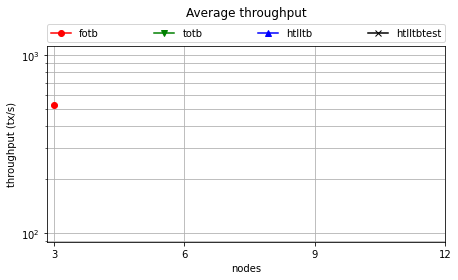

In [5]:
# throughput vs nodes

plt.figure(figsize=(1.618 * 4, 4))

# for each protocol
for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.plot(r["nodes"], r["throughput_mean"], label=protocol, marker=marker, c=col)

# plot settings
plt.xticks([3, 6, 9, 12])
plt.ylabel("throughput (tx/s)")
plt.xlabel("nodes")
plt.title(" ")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.title("Average throughput", pad=30)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

# make layout tolerable
plt.tight_layout()


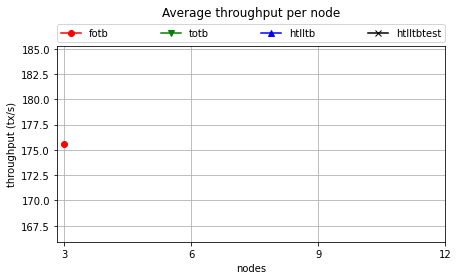

In [6]:
# average throughput per node vs nodes

plt.figure(figsize=(1.618 * 4, 4))

# for each protocol
for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.plot(r["nodes"], r["throughput_mean"] / r["nodes"], label=protocol, marker=marker, c=col)

# plot settings
plt.xticks([3, 6, 9, 12])
plt.ylabel("throughput (tx/s)")
plt.xlabel("nodes")
# plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.title("Average throughput per node", pad=30)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

# make layout tolerable
plt.tight_layout()


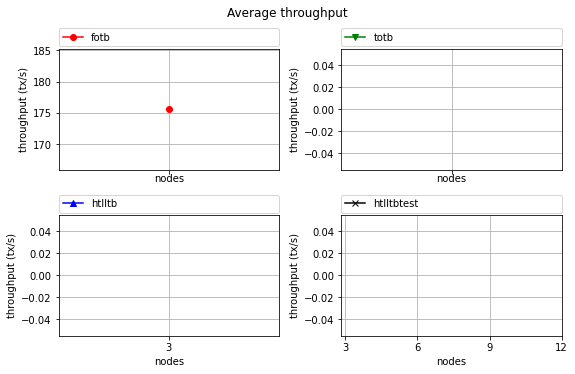

In [7]:
# throughput vs nodes per protocol
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

# for each protocol
for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    axs[i].plot(r["nodes"], r["throughput_mean"] / r["nodes"], label=protocol, marker=marker, c=col)

    # plot settings
    axs[i].set_xticks([3, 6, 9, 12])
    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("nodes")
#     axs[i].set_yscale("log")
#     axs[i].set_ylim(bottom=100)
    axs[i].grid(which="both", linestyle='-')
#     axs[i].set_title("Average throughput over time", pad=30)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

plt.suptitle("Average throughput", y=1.03)
# make layout tolerable
plt.tight_layout()


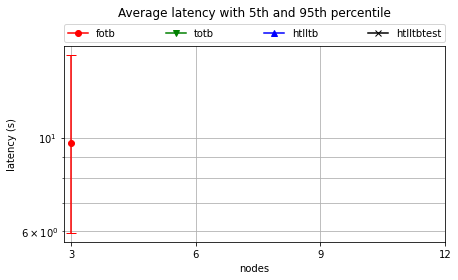

In [8]:
# latency vs nodes

plt.figure(figsize=(1.618 * 4, 4))

# for each protocol
for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    plt.plot(r["nodes"], r["latency_mean"], label=protocol, marker=marker, c=col)
    plt.errorbar(
        r["nodes"], 
        r["latency_mean"], 
        [
            r["latency_mean"] - r["latency_5th_quantile"], 
            r["latency_95th_quantile"] - r["latency_mean"]], 
        c=col,
        label=None, 
        capsize=5)

# plot settings
plt.xticks([3, 6, 9, 12])
plt.ylabel("latency (s)")
plt.xlabel("nodes")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.title("Average latency with 5th and 95th percentile", pad=30)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

# make layout tolerable
plt.tight_layout()


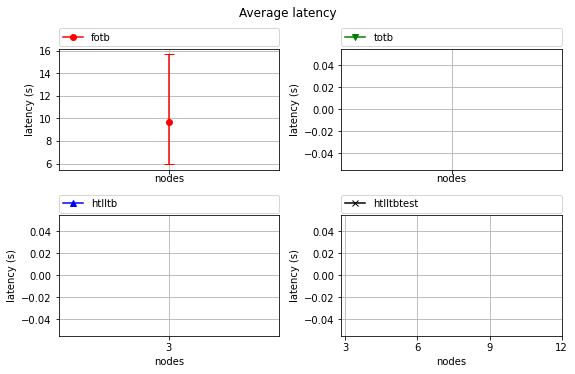

In [9]:
# latency vs nodes per protocol
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

# for each protocol
for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    axs[i].plot(r["nodes"], r["latency_mean"], label=protocol, marker=marker, c=col)
    axs[i].errorbar(
        r["nodes"], 
        r["latency_mean"], 
        [
            r["latency_mean"] - r["latency_5th_quantile"], 
            r["latency_95th_quantile"] - r["latency_mean"]], 
        c=col,
        label=None, 
        capsize=5)

    # plot settings
    axs[i].set_xticks([3, 6, 9, 12])
    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("nodes")
#     axs[i].set_yscale("log")
#     axs[i].set_ylim(bottom=100)
    axs[i].grid(which="both", linestyle='-')
#     axs[i].set_title("Average throughput over time", pad=30)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

plt.suptitle("Average latency", y=1.03)

# make layout tolerable
plt.tight_layout()


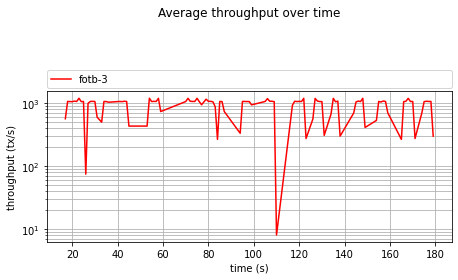

In [10]:
# throughput time series
plt.figure(figsize=(1.618 * 4, 4))

# for each protocol
for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=col, linestyle=ls)

# plot settings
plt.ylabel("throughput (tx/s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.title("Average throughput over time", pad=75)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

# make layout tolerable
plt.tight_layout()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


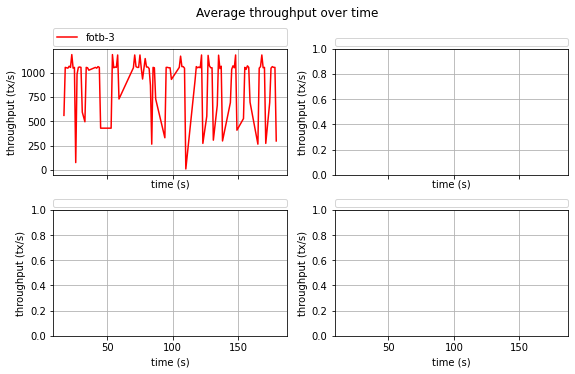

In [11]:
# throughput time series per protocol
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

# for each protocol
for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        axs[i].plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"], c=col, linestyle=ls)

    # plot settings
    axs[i].set_ylabel("throughput (tx/s)")
    axs[i].set_xlabel("time (s)")
#     axs[i].set_yscale("log")
#     axs[i].set_ylim(bottom=100)
    axs[i].grid(which="both", linestyle='-')
#     axs[i].set_title("Average throughput over time", pad=30)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

plt.suptitle("Average throughput over time", y=1.03)

# make layout tolerable
plt.tight_layout()


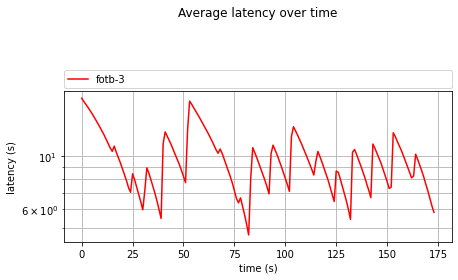

In [12]:
# latency time series
plt.figure(figsize=(1.618 * 4, 4))

# for each protocol
for protocol, col, marker in zip(protocols, colours, markers):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        plt.plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=col, linestyle=ls)

# plot settings
plt.ylabel("latency (s)")
plt.xlabel("time (s)")
plt.yscale("log")
plt.grid(which="both", linestyle='-')
plt.title("Average latency over time", pad=75)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

# make layout tolerable
plt.tight_layout()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


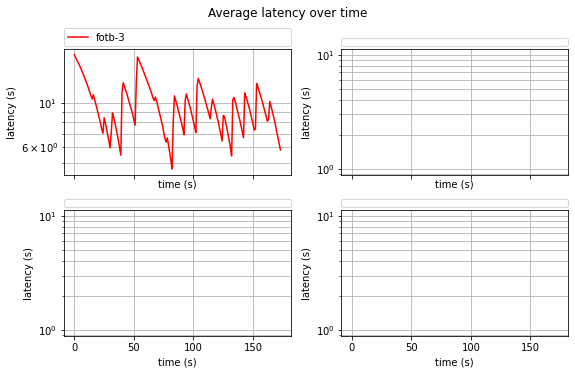

In [13]:
# latency time series per protocol
fig, axs = plt.subplots(2, 2, figsize=(1.618 * 5, 5), sharex=True)
axs = numpy.ravel(axs)

# for each protocol
for i, (protocol, col, marker) in enumerate(zip(protocols, colours, markers)):
    r = results[results["prefix"].str.contains(protocol+"-")]
    for (idx, row), ls in zip(r.iterrows(), linestyles):
        axs[i].plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"], c=col, linestyle=ls)

    # plot settings
    axs[i].set_ylabel("latency (s)")
    axs[i].set_xlabel("time (s)")
    axs[i].set_yscale("log")
#     axs[i].set_ylim(bottom=100)
    axs[i].grid(which="both", linestyle='-')
#     axs[i].set_title("Average throughput over time", pad=30)
    axs[i].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=4)  # https://stackoverflow.com/a/43439132

plt.suptitle("Average latency over time", y=1.03)

# make layout tolerable
plt.tight_layout()


In [14]:
results.filter([
    "prefix",
    "nodes", 
    "throughput_mean",
    "latency_mean",
    "latency_std",
    "latency_5th_quantile",
    "latency_95th_quantile"
])


,prefix,nodes,throughput_mean,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile
0,fotb-3,3,526.716667,9.72253,2.79536,5.943106,15.668186
